# pySHACL testing

Ocean Info Hub SHACL validation on S3(minio) objects

## Flow

* get an object (use the dask notebook)
* process the object against OIH SHACL shapes


In [10]:
%%capture
!pip install pyshacl
!pip install 'PyLD>=2.0.3'
!pip install flatten_json
!pip install 'fsspec>=0.3.3'
!pip install s3fs
!pip install boto3

In [11]:
def label_status (row):
  result = row['http://www.w3.org/ns/shacl#resultSeverity']
  if result == "nan":
    return "NA" 
  elif "Warning" in result:
    return "Warning"
  elif "Violation" in result:
    return "Violation"  
  else:
    return result

def source_shape (row):
  result = row['http://www.w3.org/ns/shacl#sourceShape']
  if type(result) is list: 
    return result[0]['@id']
  else:
    return "NA"


## Gleaner Data

First lets load up some of the data Gleaner has collected.  This is just simple data graph objects and not any graphs or other processed products from Gleaner. 

In [12]:
# Set up our S3FileSystem object
import s3fs 

oss = s3fs.S3FileSystem(
      anon=True,
      key="",
      secret="",
      client_kwargs = {"endpoint_url":"https://oss.collaborium.io"}
   )

In [13]:
# Create the Dask tasks..   created..  not run..  
import json
import dask, boto3
import dask.dataframe as dd

@dask.delayed()
def read_a_file(fn):
    # or preferably open in text mode and json.load from the file
    with oss.open(fn, 'rb') as f:
        #return json.loads(f.read().replace('\n',' '))
        return json.loads(f.read().decode("ascii", "ignore").replace('\n',' '))

# List of buckets to work with..   if you don't know them, you could print out above
buckets = ['gleaner/summoned/oceanexperts'] 
filenames = []

for d in range(len(buckets)):
  print("indexing {}".format(buckets[d]))
  f = oss.ls(buckets[d])
  filenames += f

#filenames = oss.cat('gleaner/summoned/opentopo', recursive=True)
output = [read_a_file(f) for f in filenames]
print(len(filenames))
# print(filenames)

indexing gleaner/summoned/oceanexperts
480


In [14]:
%%time 
from pyshacl import validate
from os import path
from pandas import json_normalize
import pandas as pd
import json
import rdflib
import seaborn as sns
import matplotlib.pyplot as plt

gldf = pd.DataFrame(columns=["id", "status", "shape"])

for ndx in range(len(output)):
# for ndx in range(10):
    
  if "/.jsonld" not in filenames[ndx] :
    try:
      jld = output[ndx].compute()  ## Now pull from dask..   In REAL version, move this logic into Dask!  to get the parallel approach
    except:
      print(filenames[ndx])
      print("Doc has bad encoding")

    jd = json.dumps(jld, sort_keys=True, indent=4)
        
    try:
      conforms, v_graph, v_text = validate(jd, 
                shacl_graph='./oih_learning.ttl', 
                data_graph_format="json-ld", 
                shape_graph_format="ttl", 
                inference='none', 
                serialize_report_graph="json-ld")
      
      gd = v_graph.decode("ascii") 
      df = pd.DataFrame(json.loads(gd))
      conforms = df["http://www.w3.org/ns/shacl#conforms"]
      tf = conforms[0][0]['@value']

      if "False" in str(tf):
        df['http://www.w3.org/ns/shacl#resultSeverity'] = df['http://www.w3.org/ns/shacl#resultSeverity'].astype(str)
        df['ID'] = filenames[ndx] #  'Object:{}'.format(ndx) 
        df['Status'] = df.apply (lambda row: label_status(row), axis=1)
        df['Shape'] = df.apply (lambda row: source_shape(row), axis=1)

        data = [df["ID"], df["Status"], df['Shape']]
        headers = ["id", "status", "shape"]
        df3 = pd.concat(data, axis=1, keys=headers)
        gldf = gldf.append(df3, ignore_index=True)
      elif "True" in str(tf):
        df['ID'] = filenames[ndx] #  'Object:{}'.format(ndx) 
        df['Status'] = "Valid"
        df['Shape'] = "AllPassed"

        data = [df["ID"], df["Status"], df['Shape']]
        headers = ["id", "status", "shape"]
        df3 = pd.concat(data, axis=1, keys=headers)
        gldf = gldf.append(df3, ignore_index=True)  
    
#       print("------------------")
#       print(conforms)
#       print(v_graph)
#       print(v_text)

    except:
      print("ERROR")
      df = pd.DataFrame()
      df['ID'] = filenames[ndx] #  'Object:{}'.format(ndx) 
      df['Status'] = "ErrorProcessing"
      df['Shape'] = "ErrorProcessing"

      data = [df["ID"], df["Status"], df['Shape']]
      headers = ["id", "status", "shape"]
      df3 = pd.concat(data, axis=1, keys=headers)
      gldf = gldf.append(df3, ignore_index=True)
      print("PySHACL decode error: {}",format(filenames[ndx]))



CPU times: user 14.9 s, sys: 372 ms, total: 15.3 s
Wall time: 35.8 s


In [15]:
gldf.info() 
gldf.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2044 entries, 0 to 2043
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2044 non-null   object
 1   status  2044 non-null   object
 2   shape   2044 non-null   object
dtypes: object(3)
memory usage: 48.0+ KB


,id,status,shape
0,gleaner/summoned/oceanexperts/00eae339a41708c6...,NA,NA
1,gleaner/summoned/oceanexperts/00eae339a41708c6...,Violation,http://science-on-schema.org/1.1.0/validation/...
2,gleaner/summoned/oceanexperts/00eae339a41708c6...,Violation,http://science-on-schema.org/1.1.0/validation/...
3,gleaner/summoned/oceanexperts/00eae339a41708c6...,Violation,http://science-on-schema.org/1.1.0/validation/...
4,gleaner/summoned/oceanexperts/014dbf631db7b122...,NA,NA


In [16]:
pd.value_counts(gldf['shape'])

http://science-on-schema.org/1.1.0/validation/shacl#urlResourceProperty            480
http://science-on-schema.org/1.1.0/validation/shacl#keywordsResourceProperty       480
http://science-on-schema.org/1.1.0/validation/shacl#identifierResourceProperty     480
NA                                                                                 480
http://science-on-schema.org/1.1.0/validation/shacl#descriptionResourceProperty    124
Name: shape, dtype: int64

(array([  0., 100., 200., 300., 400., 500., 600.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

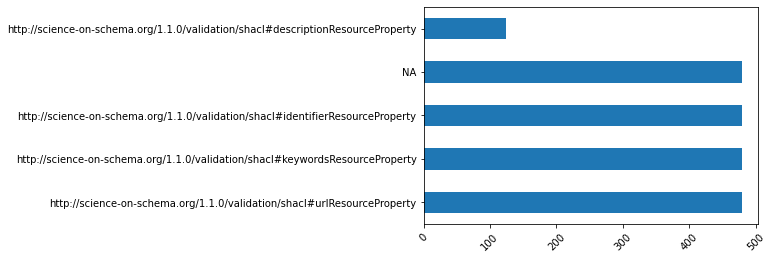

In [17]:
pd.value_counts(gldf['shape']).plot.barh()
plt.xticks(rotation=45)